<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import numpy

In [3]:
import cv2

In [4]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
max_dim = (256, 256)
show_fish = False
show_model = False

<h3>載入魚影像檔</h3>

In [8]:
def load_data(image_path, train_ratio=0.8):
    global max_dim

    image_files = glob('%s/F*.jpg' % image_path)

    my_images = []

    for image_file in image_files:
        _image_file = image_file.replace('\\', '/')

        _digit_image = cv2.imread(_image_file, cv2.COLOR_BGR2RGB)
        _digit_image = cv2.resize(_digit_image.copy(), max_dim)

        my_images.append(numpy.reshape(_digit_image, (max_dim[0], max_dim[1], 3)))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)

    pos = int(len(image_files) * train_ratio)
    return my_images[:pos], my_images[pos:]

In [9]:
def show_image(my_image):
    fig, ax = plt.subplots(dpi=120)
    ax.imshow(my_image)
    ax.axis('off')
    plt.show()

In [10]:
x_train, x_test = load_data(image_path='images/objects/train')

In [11]:
image_dimension = x_train.shape[1]

In [12]:
x_train.shape, x_test.shape

((1961, 256, 256, 3), (491, 256, 256, 3))

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

<h3>轉換 256x256 二維度為 65536 一維度</h3>

In [14]:
x_train = x_train.reshape((x_train.shape[0], numpy.prod(x_train.shape[1:])))
x_test = x_test.reshape((x_test.shape[0], numpy.prod(x_test.shape[1:])))

In [15]:
x_train.shape, x_test.shape

((1961, 196608), (491, 196608))

<h3>參數設置</h3>
<p>$$壓縮率: \frac {65536}{64} = 1024$$</p>

In [16]:
encoding_dim = 64
num_of_epoch = 512
num_of_batch_size = 8

<h3>建立模型</h3>

In [17]:
input_img = keras.Input(shape=(x_train.shape[1],), name='input')

In [18]:
encoded_384 = layers.Dense(256, name='encoded_384', activation='relu')(input_img)
encoded_256 = layers.Dense(256, name='encoded_256', activation='relu')(encoded_384)
encoded_128 = layers.Dense(128, name='encoded_128', activation='relu')(encoded_256)
encoded = layers.Dense(encoding_dim, name='latent', activation='relu')(encoded_128)

In [19]:
decoded_128 = layers.Dense(128, name='decoded_128', activation='relu')(encoded)
decoded_256 = layers.Dense(256, name='decoded_256', activation='relu')(decoded_128)
decoded_384 = layers.Dense(256, name='decoded_384', activation='relu')(decoded_256)
decoded = layers.Dense(x_train.shape[1], name='output', activation='sigmoid')(decoded_384)

In [20]:
autoencoder = keras.Model(input_img, decoded, name='autoencoder')

In [21]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 196608)]          0         
_________________________________________________________________
encoded_384 (Dense)          (None, 256)               50331904  
_________________________________________________________________
encoded_256 (Dense)          (None, 256)               65792     
_________________________________________________________________
encoded_128 (Dense)          (None, 128)               32896     
_________________________________________________________________
latent (Dense)               (None, 64)                8256      
_________________________________________________________________
decoded_128 (Dense)          (None, 128)               8320      
_________________________________________________________________
decoded_256 (Dense)          (None, 256)               

In [22]:
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))

In [24]:
decoder_layer_128 = autoencoder.layers[-4]
decoder_layer_256 = autoencoder.layers[-3]
decoder_layer_384 = autoencoder.layers[-2]
decoder_layer = autoencoder.layers[-1]

decoder = keras.Model(encoded_input, 
                      decoder_layer(decoder_layer_384(decoder_layer_256(
                          decoder_layer_128(encoded_input)))))

In [25]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

<h3>訓練模型</h3>

In [26]:
checkpointer = ModelCheckpoint(
    filepath='NLP-C-0-374-256-128.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [27]:
score = autoencoder.fit(x_train, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/512
246/246 [==============================] - 73s 293ms/step - loss: 0.3595 - val_loss: 0.3023

Epoch 00001: val_loss improved from inf to 0.30233, saving model to NLP-C-0-374-256-128.hdf5
Epoch 2/512
246/246 [==============================] - 71s 291ms/step - loss: 0.2988 - val_loss: 0.3035

Epoch 00002: val_loss did not improve from 0.30233
Epoch 3/512
246/246 [==============================] - 71s 289ms/step - loss: 0.2998 - val_loss: 0.2976

Epoch 00003: val_loss improved from 0.30233 to 0.29758, saving model to NLP-C-0-374-256-128.hdf5
Epoch 4/512
246/246 [==============================] - 72s 294ms/step - loss: 0.2945 - val_loss: 0.2935

Epoch 00004: val_loss improved from 0.29758 to 0.29353, saving model to NLP-C-0-374-256-128.hdf5
Epoch 5/512
246/246 [==============================] - 71s 290ms/step - loss: 0.2896 - val_loss: 0.2915

Epoch 00005: val_loss improved from 0.29353 to 0.29147, saving model to NLP-C-0-374-256-128.hdf5
Epoch 6/512
246/246 [===================

246/246 [==============================] - 74s 301ms/step - loss: 0.2840 - val_loss: 0.2849

Epoch 00047: val_loss did not improve from 0.28424
Epoch 48/512
246/246 [==============================] - 74s 301ms/step - loss: 0.2833 - val_loss: 0.2845

Epoch 00048: val_loss did not improve from 0.28424
Epoch 49/512
246/246 [==============================] - 74s 302ms/step - loss: 0.2812 - val_loss: 0.2850

Epoch 00049: val_loss did not improve from 0.28424
Epoch 50/512
246/246 [==============================] - 75s 304ms/step - loss: 0.2829 - val_loss: 0.2844

Epoch 00050: val_loss did not improve from 0.28424
Epoch 51/512
246/246 [==============================] - 74s 302ms/step - loss: 0.2877 - val_loss: 0.2846

Epoch 00051: val_loss did not improve from 0.28424
Epoch 52/512
246/246 [==============================] - 74s 302ms/step - loss: 0.2821 - val_loss: 0.2841

Epoch 00052: val_loss improved from 0.28424 to 0.28412, saving model to NLP-C-0-374-256-128.hdf5
Epoch 53/512
246/246 [===

246/246 [==============================] - 70s 284ms/step - loss: 0.2815 - val_loss: 0.2835

Epoch 00097: val_loss did not improve from 0.28334
Epoch 98/512
246/246 [==============================] - 71s 289ms/step - loss: 0.2820 - val_loss: 0.2846

Epoch 00098: val_loss did not improve from 0.28334
Epoch 99/512
246/246 [==============================] - 71s 287ms/step - loss: 0.2806 - val_loss: 0.2846

Epoch 00099: val_loss did not improve from 0.28334
Epoch 100/512
246/246 [==============================] - 72s 292ms/step - loss: 0.2836 - val_loss: 0.2836

Epoch 00100: val_loss did not improve from 0.28334
Epoch 101/512
246/246 [==============================] - 73s 296ms/step - loss: 0.2851 - val_loss: 0.2835

Epoch 00101: val_loss did not improve from 0.28334
Epoch 102/512
246/246 [==============================] - 73s 297ms/step - loss: 0.2816 - val_loss: 0.2834

Epoch 00102: val_loss did not improve from 0.28334
Epoch 103/512
246/246 [==============================] - 71s 290ms/s

246/246 [==============================] - 73s 299ms/step - loss: 0.2809 - val_loss: 0.2831

Epoch 00148: val_loss improved from 0.28316 to 0.28313, saving model to NLP-C-0-374-256-128.hdf5
Epoch 149/512
246/246 [==============================] - 74s 299ms/step - loss: 0.2794 - val_loss: 0.2832

Epoch 00149: val_loss did not improve from 0.28313
Epoch 150/512
246/246 [==============================] - 73s 298ms/step - loss: 0.2832 - val_loss: 0.2834

Epoch 00150: val_loss did not improve from 0.28313
Epoch 151/512
246/246 [==============================] - 74s 302ms/step - loss: 0.2837 - val_loss: 0.2858

Epoch 00151: val_loss did not improve from 0.28313
Epoch 152/512
246/246 [==============================] - 73s 298ms/step - loss: 0.2855 - val_loss: 0.2838

Epoch 00152: val_loss did not improve from 0.28313
Epoch 153/512
246/246 [==============================] - 74s 302ms/step - loss: 0.2785 - val_loss: 0.2834

Epoch 00153: val_loss did not improve from 0.28313
Epoch 154/512
246/24

246/246 [==============================] - 69s 282ms/step - loss: 0.2824 - val_loss: 0.2837

Epoch 00199: val_loss did not improve from 0.28302
Epoch 200/512
246/246 [==============================] - 70s 284ms/step - loss: 0.2805 - val_loss: 0.2839

Epoch 00200: val_loss did not improve from 0.28302
Epoch 201/512
246/246 [==============================] - 69s 281ms/step - loss: 0.2835 - val_loss: 0.2837

Epoch 00201: val_loss did not improve from 0.28302
Epoch 202/512
246/246 [==============================] - 70s 285ms/step - loss: 0.2826 - val_loss: 0.2875

Epoch 00202: val_loss did not improve from 0.28302
Epoch 203/512
246/246 [==============================] - 73s 297ms/step - loss: 0.2839 - val_loss: 0.2839

Epoch 00203: val_loss did not improve from 0.28302
Epoch 204/512
246/246 [==============================] - 73s 298ms/step - loss: 0.2832 - val_loss: 0.2834

Epoch 00204: val_loss did not improve from 0.28302
Epoch 205/512
246/246 [==============================] - 73s 296ms

246/246 [==============================] - 70s 285ms/step - loss: 0.2768 - val_loss: 0.2834

Epoch 00250: val_loss did not improve from 0.28301
Epoch 251/512
246/246 [==============================] - 70s 285ms/step - loss: 0.2824 - val_loss: 0.2847

Epoch 00251: val_loss did not improve from 0.28301
Epoch 252/512
246/246 [==============================] - 71s 291ms/step - loss: 0.2824 - val_loss: 0.2836

Epoch 00252: val_loss did not improve from 0.28301
Epoch 253/512
246/246 [==============================] - 73s 297ms/step - loss: 0.2788 - val_loss: 0.2833

Epoch 00253: val_loss did not improve from 0.28301
Epoch 254/512
246/246 [==============================] - 72s 291ms/step - loss: 0.2798 - val_loss: 0.2832

Epoch 00254: val_loss did not improve from 0.28301
Epoch 255/512
246/246 [==============================] - 75s 303ms/step - loss: 0.2823 - val_loss: 0.2831

Epoch 00255: val_loss did not improve from 0.28301
Epoch 256/512
246/246 [==============================] - 74s 301ms

<h3>模型訓練績效</h3>

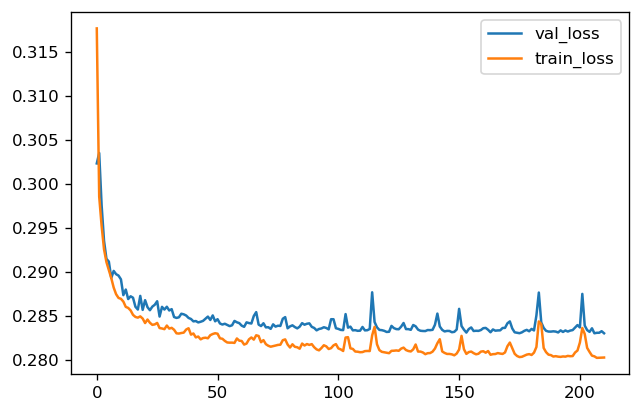

In [28]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>產生假圖</h3>

In [29]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [30]:
x_test.shape

(491, 196608)

<h3>隨機顯示抽象圖與假圖</h3>

In [31]:
i = numpy.random.randint(0, x_test.shape[0], 1)[0]

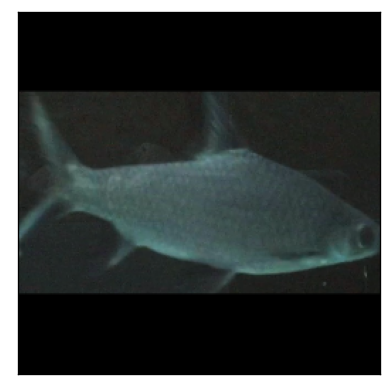

In [32]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(x_test[i].reshape(image_dimension, image_dimension, 3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

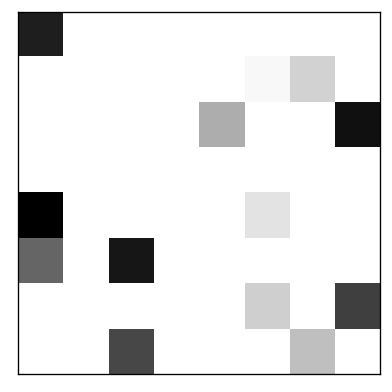

In [33]:
fig, ax = plt.subplots(dpi=120)

encode_dimension = int(encoding_dim**0.5)
ax.imshow(encoded_imgs[i].reshape(encode_dimension, encode_dimension, 1), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

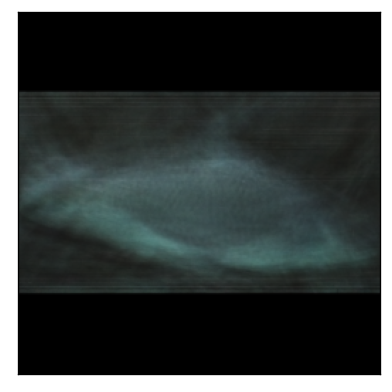

In [34]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(decoded_imgs[i].reshape(image_dimension, image_dimension, 3), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

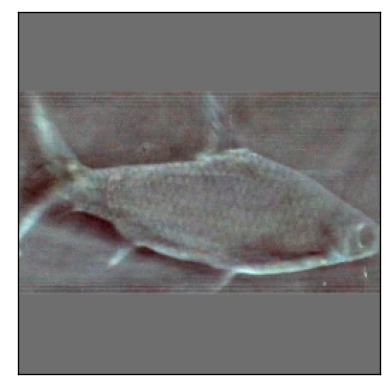

In [35]:
fig, ax = plt.subplots(dpi=120)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax.imshow(diff_image_val.reshape(image_dimension, image_dimension, 3), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

<h3>顯示原圖與假圖</h3>

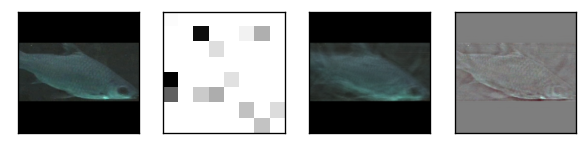

In [36]:
i = numpy.random.randint(0, x_test.shape[0], 1)[0]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(dpi=120, ncols=4)

ax0.imshow(x_test[i].reshape(image_dimension, image_dimension, 3), cmap=plt.cm.binary)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

encode_dimension = int(encoding_dim**0.5)

encoded_imgs_min = encoded_imgs[i].min()
encoded_imgs_max = encoded_imgs[i].max()
encoded_imgs_val = (encoded_imgs[i] - encoded_imgs_min) / (encoded_imgs_max - encoded_imgs_min)

ax1.imshow(encoded_imgs_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(decoded_imgs[i].reshape(image_dimension, image_dimension, 3), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax3.imshow(diff_image_val.reshape(image_dimension, image_dimension, 3), cmap=plt.cm.binary)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.show()

In [38]:
diff_image_val.mean(), diff_image_val.std()

(0.4893811, 0.029933289)

In [39]:
0.029933289 / 0.4893811

0.06116560079659798

<h3>叢集分佈</h3>

In [ ]:
rcParams['figure.figsize'] = 10, 8

fig = plt.figure(1)
ax = Axes3D(fig)

xs = encoded_imgs[:, 0]
ys = encoded_imgs[:, 1]
zs = encoded_imgs[:, 2]

y_test = [0] * encoded_imgs.shape[0]

color=['red','green','blue','lime','white','pink','aqua','violet','gold','coral']

for x, y, z, label in zip(xs, ys, zs, y_test):
    c = color[int(label)]
    ax.text(x, y, z, label, backgroundcolor=c)
    
ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_zlim(zs.min(), zs.max())

plt.show()